# A [RD](https://en.wikipedia.org/wiki/Rate%E2%80%93distortion_theory)-Comparison of (Dyadic) DWTs

Notice that the DWT transforms the complete sequence (no chunks are considered).

In [1]:
import sounddevice as sd
import pywt # pip install pywavelets
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
import zlib
import pylab
from IPython.display import display, Math

In [2]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

## Produce some sound ... for example, speak for 5 seconds
The audio signal will be used to compare the RD performance of the transforms.

In [3]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")
x = x.flatten()

Say something!
done


## This is your audio

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


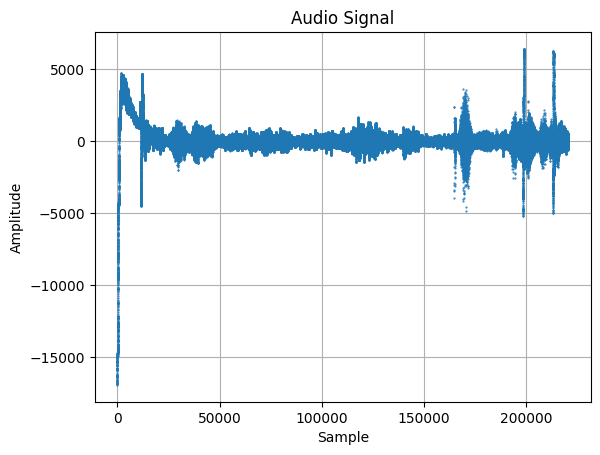

In [4]:
%matplotlib inline
sd.play(x)
plot(x, "Sample", "Amplitude", "Audio Signal")

## Let's remove some samples from the begining

In [5]:
x = x[50000:]

## This is your definitive audio sequence

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


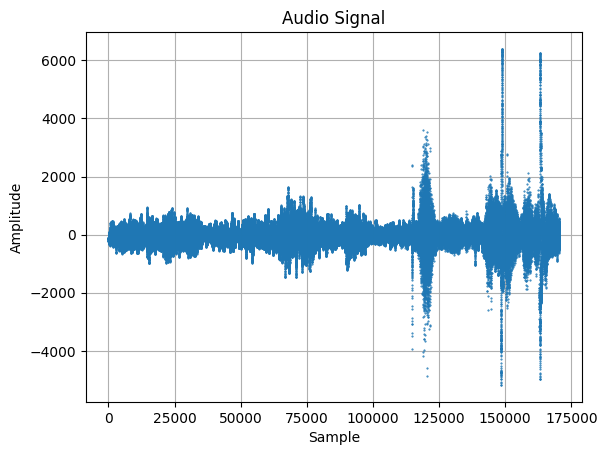

In [6]:
%matplotlib inline
sd.play(x)
plot(x, "Sample", "Amplitude", "Audio Signal")

### Configuration

In [16]:
N_levels = 5          # Number of levels of the DWT
signal_mode_extension = "per"
Delta = 32
max_Delta = 1024
Q_steps = range(Delta, max_Delta, Delta)

## [Filter's response in the frequency domain](https://en.wikipedia.org/wiki/Filter_(signal_processing)#The_transfer_function)

In [8]:
def average_complex_energy(x):
    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \
    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])
    return np.sum(x.real.astype(np.double)*x.real.astype(np.double) +
                  x.imag.astype(np.double)*x.imag.astype(np.double))/len(x)

### Orthogonal filters (1 level)

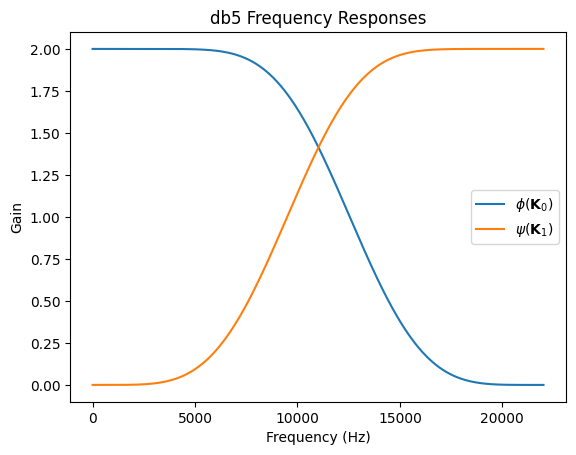

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
%matplotlib inline

#filters_name = "haar"
filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
#filters_name = "db20"
wavelet = pywt.Wavelet(filters_name)

K0, K1, __ = wavelet.wavefun(level=1) # For orthogonal transforms
# phi, psi, x
w0, h0 = signal.freqz(K0, fs=44100)
w1, h1 = signal.freqz(K1, fs=44100)

plt.title(f'{filters_name} Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.plot(w0, abs(h0), label="$\\phi (\mathbf{K}_0)$")
plt.plot(w1, abs(h1), label="$\\psi (\mathbf{K}_1)$")
plt.legend(loc="best")

plt.show()

display(Math("\\text{Average energy of}~" + "\mathbf{K}_0" + f" = {average_complex_energy(h0)}"))
display(Math("\\text{Average energy of}~" + "\mathbf{K}_1" + f" = {average_complex_energy(h1)}"))

### Orthogonal filters (more than 1 level)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

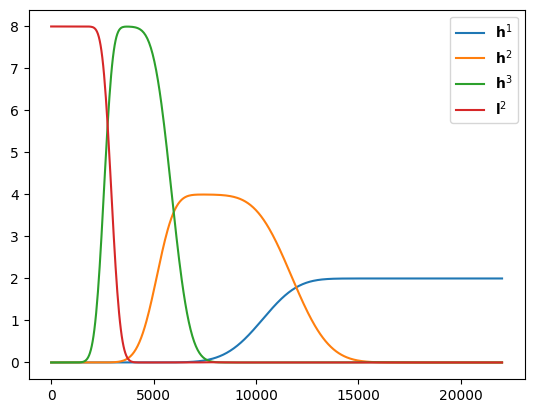

In [10]:
%matplotlib inline

filters_name = "haar"
#filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
filters_name = "db20"
wavelet = pywt.Wavelet(filters_name)

N_levels = 3

for l in range(N_levels):
    filters = wavelet.wavefun(level = (l+1))[:-1]
    w0, h0 = signal.freqz(filters[0], fs=44100)
    w1, h1 = signal.freqz(filters[1], fs=44100)
    #plt.plot(w0, abs(h0))
    plt.plot(w1, abs(h1), label="$\\mathbf{h}$" + f"$^{l+1}$")
    #print(f"Average energy of K_{l} = {average_complex_energy(h1)}")
    display(Math("\\text{Average energy of}~" + "\mathbf{h}" + f"^{l+1}" + f" = {average_complex_energy(h1)}"))
plt.plot(w0, abs(h0), label="$\\mathbf{l}$" + f"$^{l}$")
#print(f"Average energy of K_{l} = {average_complex_energy(h1)}")
display(Math("\\text{Average energy of}~" + "\mathbf{l}" + f"^{l+1}" + f" = {average_complex_energy(h0)}"))
plt.legend(loc="best")
plt.show()

Notice that, after the decimation by 2, the definitive energy of each subband remains equal to 1.

### Finally, let's see how to obtain the synthesis filters using the inverse transform

This can be useful if we don't have the taps of the synthesis filters.

The taps of the synthesis filters can be obtained filtering a unit impulse signal. If we have only two filters, we will have to use two different unit impulses. If we have more filters (regardless if the filters are or not the results of a cascade of filters), more different combinations of unit impulses need to be considered.

In [11]:
def get_filter(wavelet, coef_index, N):
    '''Generate the taps of the inverse transform setting a delta in the transform
    domain and running the inverse transform.'''
    zeros = np.zeros(N)
    decomposition = pywt.wavedec(zeros, wavelet=wavelet, level=1, mode="per")
    coefficients, slices = pywt.coeffs_to_array(decomposition)
    coefficients[coef_index] = 1
    decomposition = pywt.array_to_coeffs(coefficients, slices, output_format="wavedec")
    samples = pywt.waverec(decomposition, wavelet=wavelet, mode="per")
    return samples

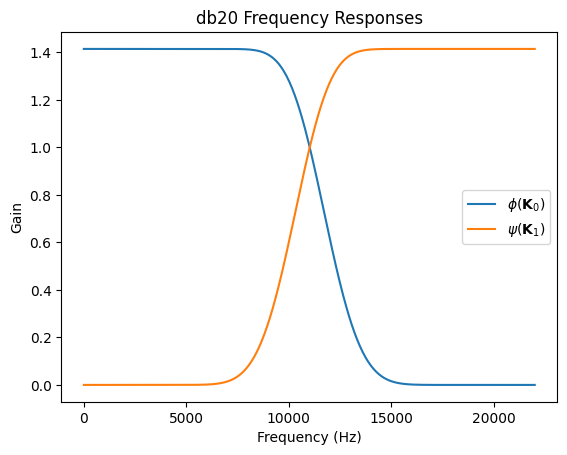

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
%matplotlib inline
#K0, K1, __ = wavelet.wavefun(level=1) # For orthogonal transforms
#K0_basis, K0_dual, K1_basis, K1_dual__ = wavelet.wavefun(level=1) # For bi-orthogonal transforms
#K0 = get_filter(wavelet, 8, 64)
#K1 = get_filter(wavelet, 56, 64)
K0 = get_filter(wavelet, 32, 128)
K1 = get_filter(wavelet, 96, 128)
w0, h0 = signal.freqz(K0, fs=44100)
w1, h1 = signal.freqz(K1, fs=44100)

plt.title(f'{filters_name} Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.plot(w0, abs(h0), label="$\\phi (\mathbf{K}_0)$")
plt.plot(w1, abs(h1), label="$\\psi (\mathbf{K}_1)$")
plt.legend(loc="best")

plt.show()

display(Math("\\text{Average energy of}~" + "\mathbf{K}_0" + f" = {average_complex_energy(h0)}"))
display(Math("\\text{Average energy of}~" + "\mathbf{K}_1" + f" = {average_complex_energy(h1)}"))

As it can be seen, the gain is ~1 for both filters (for both, the analysis and the synthesis). When the DWT domain is quantized, this implies that the quantization error will be multiplied by the same gain in all the subbands.

### Bi-orthogonal filters

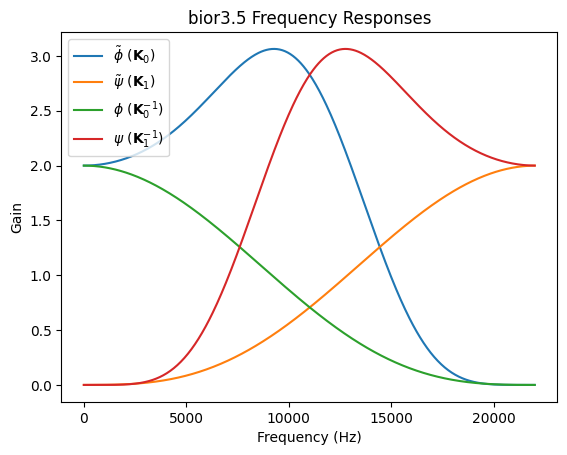

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
%matplotlib inline

#filters_name = "bior1.1"
#filters_name = "bior2.2"
filters_name = "bior3.5"
#filters_name = "rbio2.2"
wavelet = pywt.Wavelet(filters_name)

#K0, K1, __ = wavelet.wavefun(level=1) # For orthogonal transforms
K0_basis, K1_basis, K0_dual, K1_dual, __ = wavelet.wavefun(level=1) # For bi-orthogonal transforms
# phi_d, psi_d, phi_r, psi_r, x
w0_basis, h0_basis = signal.freqz(K0_basis, fs=44100)
w1_basis, h1_basis = signal.freqz(K1_basis, fs=44100)
w0_dual, h0_dual = signal.freqz(K0_dual, fs=44100)
w1_dual, h1_dual = signal.freqz(K1_dual, fs=44100)

plt.title(f'{filters_name} Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.plot(w0_basis, abs(h0_basis), label="$\\tilde\\phi~(\mathbf{K}_0)$")
plt.plot(w1_basis, abs(h1_basis), label="$\\tilde\\psi~(\mathbf{K}_1)$")
plt.plot(w0_dual, abs(h0_dual), label="$\\phi~(\mathbf{K}_0^{-1})$")
plt.plot(w1_dual, abs(h1_dual), label="$\\psi~(\mathbf{K}_1^{-1})$")
plt.legend(loc="best")

plt.show()

display(Math("\\text{Average energy of}~" + "\\tilde\\phi~(\mathbf{K}_0)" + f" = {average_complex_energy(h0_basis)}"))
display(Math("\\text{Average energy of}~" + "\\tilde\\psi~(\mathbf{K}_1)" + f" = {average_complex_energy(h0_dual)}"))
display(Math("\\text{Average energy of}~" + "\\phi~(\mathbf{K}_0^{-1})" + f" = {average_complex_energy(h1_basis)}"))
display(Math("\\text{Average energy of}~" + "\\psi~(\mathbf{K}_1^{-1})" + f" = {average_complex_energy(h1_dual)}"))

As it can be seen,  $\psi\bot\tilde\phi$ and $\phi\bot\tilde\psi$. Moreover, now the gain of the subbands after considering the decimation, is not constant.

### Total gain of the filters

The gain of the synthesis filters can be computed as the squared norm ($L^2$ norm) of the inverse transform of a [unit impulse](https://en.wikipedia.org/?title=Unit_impulse&redirect=no). To understand why this happens, consider that if in the transform domain we have a unit impulse, this mean that at the input we have exactly the corresponding filter, and obviously, the synthesis transform is going to synthesize such input.

In [17]:
# Orthogonal
#filters_name = "haar"
#filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
#filters_name = "db20"

# Bi-orthogonal
#filters_name = "bior1.1"
#filters_name = "bior2.2"
filters_name = "bior3.5"
#filters_name = "rbio2.2"

wavelet = pywt.Wavelet(filters_name)
K0 = get_filter(wavelet, 32, 128)
K1 = get_filter(wavelet, 96, 128)
w0, h0 = signal.freqz(K0, fs=44100)
w1, h1 = signal.freqz(K1, fs=44100)

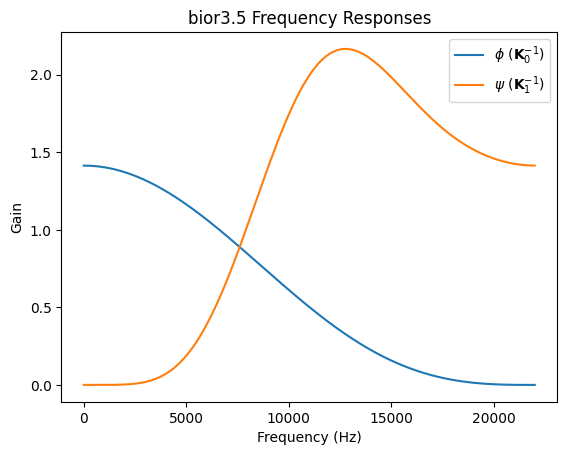

In [18]:
%matplotlib inline
plt.title(f'{filters_name} Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.plot(w0, abs(h0), label="$\\phi~(\mathbf{K}_0^{-1})$")
plt.plot(w1, abs(h1), label="$\\psi~(\mathbf{K}_1^{-1})$")
plt.legend(loc="best")

plt.show()

In [19]:
display(Math("\\text{Average energy of}~" + "\mathbf{K}_0^{-1}" + f" = {average_complex_energy(h0)}"))
display(Math("\\text{Average energy of}~" + "\mathbf{K}_1^{-1}" + f" = {average_complex_energy(h1)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now we can see that for bi-orthogonal transforms, the gain of the subbands is different.

### Conclusion

Orthogonal transforms implemented in PyWavelets have the same gain in both filters, but this is not true for bi-orthogonal transforms. In general, the low frequency subbands in bi-orthogonal subbands need a higher dynamic range.

## Testing the gain of the full transformation
The forward (analysis) and the backward (synthesis) transforms.

In [20]:
def average_energy(x):
    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \
    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def analyze(chunk, wavelet, N_levels):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=N_levels,
                                 mode=signal_mode_extension)
    return decomposition

def synthesize(decomposition, wavelet):
    reconstructed_chunk = pywt.waverec(decomposition, wavelet=wavelet,
                                       mode=signal_mode_extension)
    return reconstructed_chunk

In [21]:
# Orthogonal
#filters_name = "haar"
#filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
#filters_name = "db20"

# Bi-orthogonal (but not orthogonal)
#filters_name = "bior1.1"
#filters_name = "bior2.2"
#filters_name = "bior3.5"
filters_name = "rbio2.2"

wavelet = pywt.Wavelet(filters_name)

y = analyze(x, wavelet, 3)
z = synthesize(y, wavelet)
print(average_energy(x), average_energy(z))

264657.70185337245 264657.70185337245


You can check that all transform are energy preserving. This means that after the full transform, no amplification nor attenuation will be experimented.

## RD (Rate Distortion) curves

### Some RD stuff

In [22]:
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def deadzone_quantize(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def deadzone_dequantize(k, quantization_step):
    y = quantization_step * k
    return y

def deadzone_qdeq(x, quantization_step):
    k = deadzone_quantize(x, quantization_step)
    y = deadzone_dequantize(k, quantization_step)
    return k, y

def quantize(decomposition, q_steps):
    quantized_decomposition = []
    for subband, q_step in zip(decomposition, q_steps):
        quantized_subband = deadzone_quantize(subband, q_step)
        quantized_decomposition.append(quantized_subband)
    return quantized_decomposition

def analyze_and_quantize(chunk, wavelet, N_levels, q_steps):
    decomposition = analyze(chunk, wavelet, N_levels)
    quantized_decomposition = quantize(decomposition, q_steps)
    return quantized_decomposition

def dequantize(quantized_decomposition, q_steps):
    dequantized_decomposition = []
    for subband, q_step in zip(quantized_decomposition, q_steps):
        dequantized_subband = deadzone_dequantize(subband, q_step)
        dequantized_decomposition.append(dequantized_subband)
    return dequantized_decomposition

def dequantize_and_synthesize(quantized_decomposition, wavelet, q_steps):
    dequantized_decomposition = dequantize(quantized_decomposition, q_steps)
    reconstructed_chunk = synthesize(dequantized_decomposition, wavelet)
    return reconstructed_chunk

### Basic RD curve using the RMSE VS the entropy

In [23]:
def RD_curve_entropy(chunk, wavelet, N_levels):
    RD_points = []
    for q_step in Q_steps:
        q_steps = [q_step] * (N_levels + 1)
        quantized_decomposition = analyze_and_quantize(chunk, wavelet, N_levels, q_steps)
        k = np.concatenate(quantized_decomposition)
        #rate = 8*len(zlib.compress(k.copy()))/len(chunk)
        rate = entropy_in_bits_per_symbol(k) + entropy_in_bits_per_symbol(k)
        reconstructed_chunk = dequantize_and_synthesize(quantized_decomposition, wavelet, q_steps)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [24]:
N_levels = 6

# Orthogonal
#filters_name = "haar"
#filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
#filters_name = "db20"

# Bi-orthogonal
#filters_name = "bior1.1"
#filters_name = "bior2.2"
filters_name = "bior3.5"
#filters_name = "rbio2.2"

wavelet = pywt.Wavelet(filters_name)

In [25]:
#RD_points = RD_curve(x[0:frames_per_chunk], wavelet, 3)
RD_points_entropy = RD_curve_entropy(x, wavelet, N_levels)

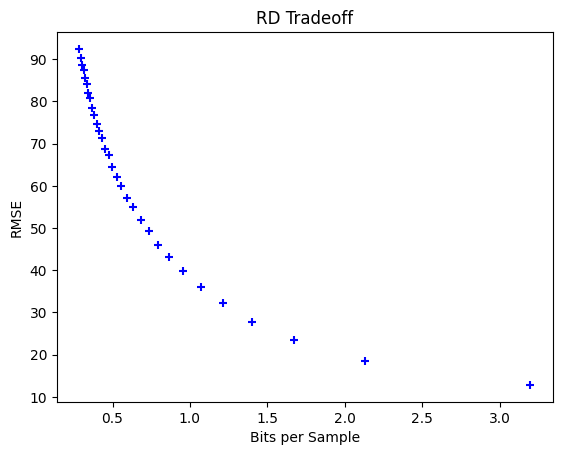

In [26]:
%matplotlib inline
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*RD_points_entropy), c='b', marker="+", label=f'{wavelet}')
#plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
#plt.legend(loc='upper right')
plt.show()

### RD curve using DEFLATE

In [27]:
def RD_curve_DEFLATE(chunk, wavelet, N_levels):
    RD_points = []
    for q_step in Q_steps:
        q_steps = [q_step] * (N_levels + 1)
        quantized_decomposition = analyze_and_quantize(chunk, wavelet, N_levels, q_steps)
        #print(len(quantized_decomposition[3]))
        k = np.concatenate(quantized_decomposition)
        rate = 8*len(zlib.compress(k.copy()))/len(chunk)
        #print(len(zlib.compress(k.copy())))
        #rate = entropy_in_bits_per_symbol(k) + entropy_in_bits_per_symbol(k)
        reconstructed_chunk = dequantize_and_synthesize(quantized_decomposition, wavelet, q_steps)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [28]:
RD_points_DEFLATE = RD_curve_DEFLATE(x, wavelet, N_levels)
#print(RD_points_DEFLATE)

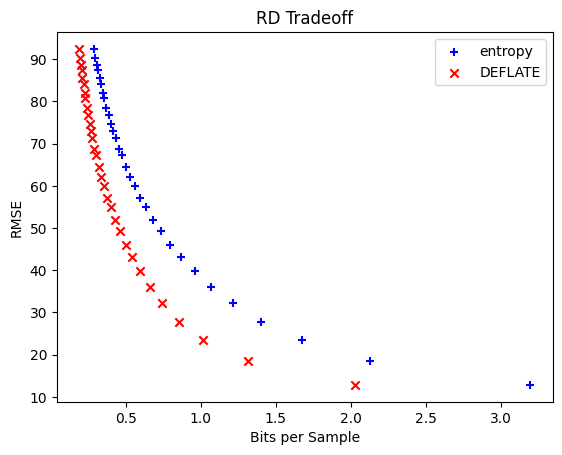

In [29]:
%matplotlib inline
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*RD_points_entropy), c='b', marker="+", label='entropy')
plt.scatter(*zip(*RD_points_DEFLATE), c='r', marker="x", label='DEFLATE')
plt.legend(loc='upper right')
plt.show()

DEFLATE performs better than considering the entropy, and both curves are highly correlated.

In [30]:
def normalized_gains(N_samples, wavelet, N_levels):
    gains = []
    chunk = np.zeros(N_samples)
    decomposition = analyze(chunk, wavelet, N_levels)
    decomposition[0][len(decomposition[0])//2] = 1
    reconstructed_chunk = synthesize(decomposition, wavelet)
    gains.append(average_energy(reconstructed_chunk))
    prev_sb = decomposition[0]
    for sb in decomposition[1:]:
        prev_sb[...] = 0
        sb[len(sb)//2] = 1
        reconstructed_chunk = synthesize(decomposition, wavelet)
        gains.append(average_energy(reconstructed_chunk))
        prev_sb = sb
    
    return gains/sum(gains)

In [31]:
gains = normalized_gains(1024, wavelet, N_levels)
print(gains)

[0.08293553 0.11403733 0.11434792 0.11560522 0.12087312 0.14576404
 0.30643685]


In [32]:
def RD_curve_entropy_gains(chunk, wavelet, N_levels, gains):
    # The gains has been used with the squared norm!
    Q_factors = np.array([math.sqrt(gains[0]/i) for i in gains])
    RD_points = []
    for q_step in Q_steps:
        q_steps = q_step / Q_factors
        quantized_decomposition = analyze_and_quantize(chunk, wavelet, N_levels, q_steps)
        k = np.concatenate(quantized_decomposition)
        #rate = 8*len(zlib.compress(k.copy()))/len(chunk)
        rate = entropy_in_bits_per_symbol(k) + entropy_in_bits_per_symbol(k)
        reconstructed_chunk = dequantize_and_synthesize(quantized_decomposition, wavelet, q_steps)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [33]:
RD_points_entropy_gains = RD_curve_entropy_gains(x, wavelet, N_levels, gains)

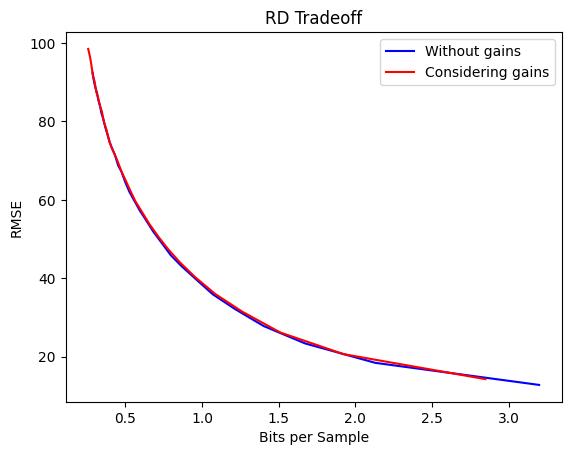

In [34]:
%matplotlib inline
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.plot(*zip(*RD_points_entropy), c='b', label='Without gains')
plt.plot(*zip(*RD_points_entropy_gains), c='r', label='Considering gains')
plt.legend(loc='upper right')
plt.show()

In [35]:
def RD_curve_DEFLATE_gains(chunk, wavelet, N_levels, gains):
    # The gains has been used with the squared norm!
    Q_factors = np.array([math.sqrt(gains[0]/i) for i in gains])
    print("Didiving QSS by ", Q_factors)
    RD_points = []
    for q_step in Q_steps:
        # The bigger the quantization step size, the larger the Q error
        q_steps = q_step / Q_factors
        quantized_decomposition = analyze_and_quantize(chunk, wavelet, N_levels, q_steps)
        k = np.concatenate(quantized_decomposition)
        rate = 8*len(zlib.compress(k.copy()))/len(chunk)
        #rate = entropy_in_bits_per_symbol(k) + entropy_in_bits_per_symbol(k)
        reconstructed_chunk = dequantize_and_synthesize(quantized_decomposition, wavelet, q_steps)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

In [36]:
RD_points_DEFLATE_gains = RD_curve_DEFLATE_gains(x, wavelet, N_levels, gains)

Didiving QSS by  [1.         0.85279923 0.85164024 0.84699645 0.82833392 0.75430174
 0.5202353 ]


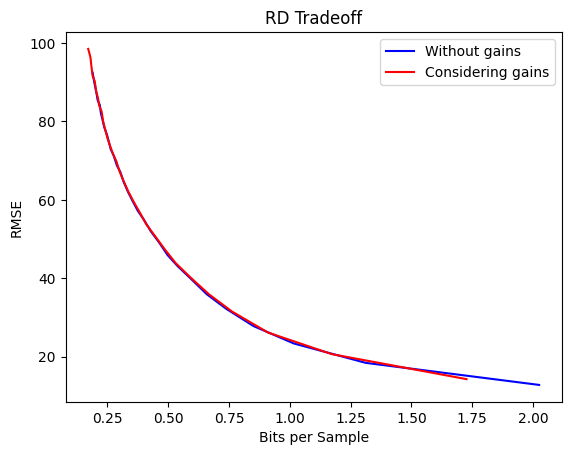

In [37]:
%matplotlib inline
plt.title("RD Tradeoff")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.plot(*zip(*RD_points_DEFLATE), c='b', label='Without gains')
plt.plot(*zip(*RD_points_DEFLATE_gains), c='r', label='Considering gains')
plt.legend(loc='upper right')
plt.show()

### Conclusions about the filter gains and the quantization step size
1. For orthogonal transforms, there results is exactly the same.
2. For bi-orthogonal transforms, there is a minor advantage on modulating the quantization step sizes with the relative gains.

### Impact of  each subband in the distortion of the reconstructed chunk

In [38]:
def subbands_DEFLATE_RD_curve(chunk, wavelet, N_levels):
    '''RD curves per subband.'''    
    subbands_RD_points = [None] * (N_levels + 1)
    decomposition = analyze(chunk, wavelet, N_levels)
    #print(len(decomposition))
    for l in range(N_levels + 1):
        #print(len(chunk), len(decomposition[l]))
        #print(decomposition)
        zero_chunk = np.zeros_like(chunk)
        zero_decomposition = analyze(zero_chunk, wavelet, N_levels)
        zero_decomposition[l][:] = decomposition[l]
        #print(decomposition[l])
        subbands_RD_points[l] = []
        for q_step in Q_steps:
            #print(q_step)
            quantized_subband = deadzone_quantize(zero_decomposition[l], q_step)
            zero_decomposition[l][:] = quantized_subband
            k = np.concatenate(zero_decomposition)
            rate = 8*len(zlib.compress(k.copy()))/len(chunk)
            dequantized_subband = deadzone_dequantize(quantized_subband, q_step)
            zero_decomposition[l][:] = dequantized_subband
            reconstructed_chunk = synthesize(zero_decomposition, wavelet)
            distortion = RMSE(chunk, reconstructed_chunk)
            #print(l, rate, distortion)
            subbands_RD_points[l].append((rate, distortion))
        subbands_RD_points[l].reverse()

    return subbands_RD_points

In [39]:
subband_DEFLATE_RD_points = subbands_DEFLATE_RD_curve(x, wavelet, N_levels)

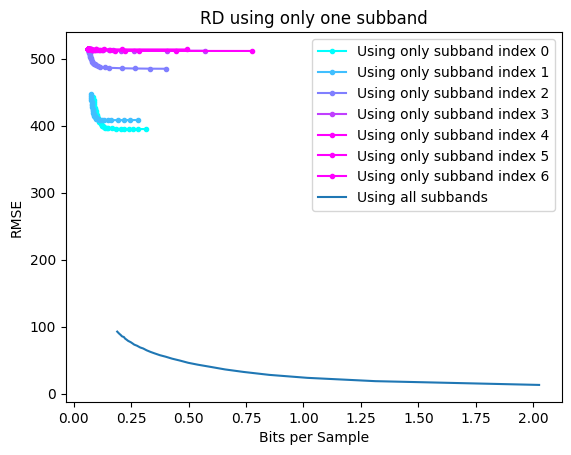

RMSE (using only zeros) = 514.4489302674974


In [40]:
%matplotlib inline
from matplotlib import cm
plt.title("RD using only one subband")
plt.xlabel("Bits per Sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
i = 0
for s in subband_DEFLATE_RD_points:
    plt.plot(*zip(*s), marker=".", label=f'Using only subband index {i}', color=cm.cool(i/4))
    i += 1
plt.plot(*zip(*RD_points_DEFLATE), label="Using all subbands")
plt.legend(loc='best')
plt.show()
print("RMSE (using only zeros) =", RMSE(x, np.zeros(x.shape)))

<IPython.core.display.Javascript object>


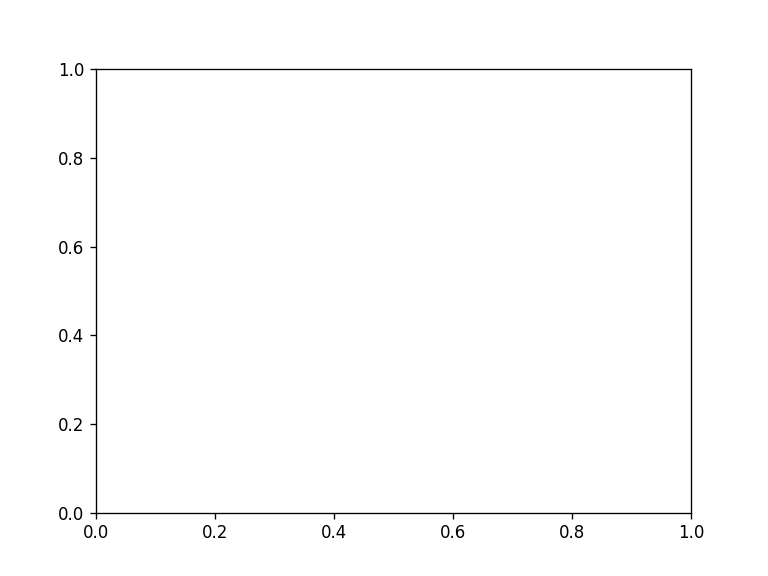

In [17]:
%matplotlib notebook
fig, ax = plt.subplots()

def animate(frame):
    i = 0
    #plt.xscale("log")
    #plt.yscale("log")
    plt.xscale("linear")
    plt.yscale("linear")
    plt.xlabel("Bits per Sample")
    plt.ylabel("RMSE")
    for s in subband_DEFLATE_RD_points:
        plt.title(f"$\Delta={max_Delta - frame*Delta}$")
        plt.plot(*zip(*s[0:frame]), marker=".", color=cm.cool(i/4))
        # Plotear además la reconstrucción
        plt.plot(*zip(*RD_points_DEFLATE[::-1][0:frame]), color='black')
        i += 1
    #return plt,
    
def init():
    for s in subband_DEFLATE_RD_points:
        plt.plot(*zip(*s), marker=".", color='white')
    plt.plot(*zip(*RD_points_DEFLATE[::-1]), color="white")
    #return plt,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=1000, frames=len(Q_steps), repeat=True)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

## Conclusions
1. The $\mathbf{l}^{l+1}$ subband is, with a lot of difference, the most important subband.
2. The $\mathbf{h}^1$ subband is, with a lot of difference, the least important one.
3. If we use the same quantization step size for all the subbands, the quality of the reconstruction should be good because the *quality layers* are used by their slope. This is true, even for bi-orthogonal transforms.
4. Bi-orthogonal filters behave like orthogonal ones.

## Extra considerations
1. Bi-orthogonal subbands are "in-phase", which means that we can establish a spatial/temporal relation between the coefficients of different subbands.
2. The previous aspect cannot be done for orthogonal wavelet transforms, except when the length of the filters is 2.